In [1]:
import pybedtools
from pybedtools.featurefuncs import midpoint

chr_dict = {"1": "chr1",
            "2": "chr2",
            "3": "chr3",
            "4": "chr4",
            "5": "chr5",
            "6": "chr6",
            "7": "chr7",
            "8": "chr8",
            "9": "chr9",
            "10": "chr10",
            "11": "chr11",
            "12": "chr12",
            "13": "chr13",
            "14": "chr14",
            "15": "chr15",
            "16": "chr16",
            "17": "chr17",
            "18": "chr18",
            "19": "chr19",
            "20": "chr20",
            "21": "chr21",
            "22": "chr22",
            "X": "chrX",
            "Y": "chrY",
            "MT": "chrM"}

chr_dict_rev = {"chr1": "1",
                "chr2": "2",
                "chr3": "3",
                "chr4": "4",
                "chr5": "5",
                "chr6": "6",
                "chr7": "7",
                "chr8": "8",
                "chr9": "9",
                "chr10": "10",
                "chr11": "11",
                "chr12": "12",
                "chr13": "13",
                "chr14": "14",
                "chr15": "15",
                "chr16": "16",
                "chr17": "17",
                "chr18": "18",
                "chr19": "19",
                "chr20": "20",
                "chr21": "21",
                "chr22": "22",
                "chrX": "X",
                "chrY": "Y",
                "chrM": "MT"}

def GRCh37_to_hg19(feature):
    if str(feature.chrom) in chr_dict:
        feature.chrom = chr_dict[str(feature.chrom)]
    #discard non-standard chromosomes
    elif str(feature.chrom) not in chr_dict_rev:
        feature = ''
    return feature

# bed file not included in repo, can be generated from https://www.repeatmasker.org/genomes/hg19/RepeatMasker-rm405-db20140131/hg19.fa.out.gz
repeats = pybedtools.BedTool("Files/hg19_transposons_20140131_sorted.bed").filter(lambda f: False if f.chrom == "chrY" else True).saveas()

In [2]:
promoters = pybedtools.BedTool("Files/protein_coding_2.5kb_each.bed").each(GRCh37_to_hg19).sort().filter(lambda f: False if f.chrom == "chrY" else True).saveas()

In [4]:
krab_name = "ZNF808"
krab = pybedtools.BedTool("Files/" + krab_name + "_peaks_processed_score_signal_exo.bed").each(GRCh37_to_hg19).filter(lambda f: False if float(f.score) < 100.0 else True).each(midpoint).sort()
#take center bp to make things cleaner
krab = krab.each(midpoint).filter(lambda f: False if f.chrom == "chrY" else True).saveas()

In [5]:
#remove Y chromosome
#total binding sites for kzfp
total_kzfp = len(krab)
#number of TE AND promoter, remove from both others
total_kzfp_TE_promoter = len(krab.intersect(promoters, u=True, sorted=True).intersect(repeats, u=True, sorted=True))

#number of binding sites that overlap with TE, unique
total_kzfp_TE = len(krab.intersect(repeats, u=True, sorted=True, f=0.5, F=0.5, e=True)) - total_kzfp_TE_promoter
#number of binding sites within promoters, 2.5kb - make a graph of distance
total_kzfp_promoter = len(krab.intersect(promoters, u=True, sorted=True)) - total_kzfp_TE_promoter
#number of non-TE, non-promoter binding sites
total_kzfp_others = total_kzfp - total_kzfp_TE - total_kzfp_promoter - total_kzfp_TE_promoter

In [6]:
print(total_kzfp)
print(total_kzfp_TE)
print(total_kzfp_promoter)
print(total_kzfp_TE_promoter)
print(total_kzfp_others)

2849
2003
101
52
693


In [7]:
percent_kzfp_TE = total_kzfp_TE / total_kzfp
percent_kzfp_promoter = total_kzfp_promoter / total_kzfp
percent_kzfp_TE_promoter = total_kzfp_TE_promoter / total_kzfp
percent_kzfp_others = total_kzfp_others / total_kzfp

print(percent_kzfp_TE)
print(percent_kzfp_promoter)
print(percent_kzfp_TE_promoter)
print(percent_kzfp_others)

0.7030537030537031
0.03545103545103545
0.018252018252018252
0.24324324324324326


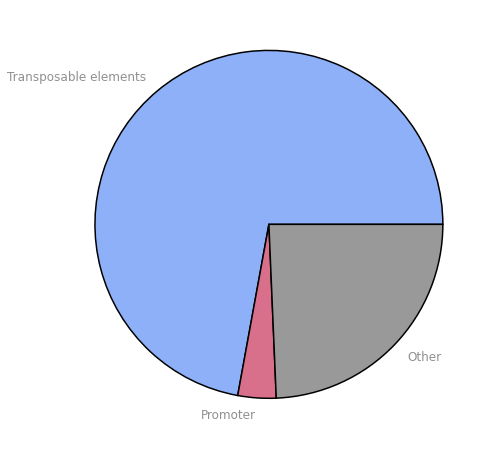

In [8]:
import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib.font_manager
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,8))
#plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size'] = 12

color_palette_list = ['#8db0f8', '#d86f8b', '#999999',]
#color_palette_list = sns.color_palette('pastel')[0:5]
labels = ['Transposable elements', 
          'Promoter',
          'Other',
         ]
percentages = [percent_kzfp_TE + percent_kzfp_TE_promoter, percent_kzfp_promoter, percent_kzfp_others]


explode=(0,0,0,0)
ax.pie(percentages, labels=labels,  
       colors=color_palette_list, 
       shadow=False, startangle=0, wedgeprops = { 'linewidth':1.5, "edgecolor":"black", 'antialiased': True}  )

#ax.set_title(krab_name)
#ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.savefig("myimg.svg")

In [13]:
#scale others per time evolution

In [9]:
import pandas as pd
from pybedtools import featurefuncs
#TE details
#out of those, all families, above 5%, bundle the rest as others
kzfp_TE = repeats.intersect(krab, u=True, sorted=True, f=0.5, F=0.5, e=True, wa=True)
kzfp_TE_df = kzfp_TE.to_dataframe()
kzfp_TE_group_df = pd.DataFrame(kzfp_TE_df.groupby("name").size(), columns=['Count'])
kzfp_TE_group_df["percentage"] = kzfp_TE_group_df / len(kzfp_TE)
kzfp_TE_group_df["significant"] = 0
kzfp_TE_group_df.loc[kzfp_TE_group_df['percentage'] >= 0.01, 'significant'] = 1

print(kzfp_TE_group_df.sort_values(by='percentage'))
print(kzfp_TE_group_df.sort_values(by='percentage').sum())

            Count  percentage  significant
name                                      
MER77B          1    0.000485            0
MLT1J2          1    0.000485            0
MER20           1    0.000485            0
MLT1J2-int      1    0.000485            0
MER21C          1    0.000485            0
...           ...         ...          ...
LTR7Y          56    0.027184            1
LTR7B         168    0.081553            1
MER11C        219    0.106311            1
MER11B        368    0.178641            1
MER11A        758    0.367961            1

[209 rows x 3 columns]
Count          2060.0
percentage        1.0
significant       6.0
dtype: float64


In [10]:
kzfp_TE_group_df.sort_values(by='percentage', ascending=False)[0:10]

,Count,percentage,significant
name,,,
MER11A,758,0.367961,1
MER11B,368,0.178641,1
MER11C,219,0.106311,1
LTR7B,168,0.081553,1
LTR7Y,56,0.027184,1
L2a,35,0.016990,1
L2c,16,0.007767,0
L1PA7,14,0.006796,0
MIRb,13,0.006311,0


In [11]:
kzfp_TE_group_df.loc['MER11A', 'percentage']

0.3679611650485437

In [12]:
kzfp_TE_group_df[~kzfp_TE_group_df.index.isin(['MER11A', 'MER11B', 'MER11C'])]['percentage'].sum()

0.34708737864077666

In [13]:
kzfp_TE_group_df[~kzfp_TE_group_df.index.isin(['MER11A', 'MER11B', 'MER11C'])].sum()

Count          715.000000
percentage       0.347087
significant      3.000000
dtype: float64

([<matplotlib.patches.Wedge at 0x7f6008f9dd00>,
 [Text(0.4433198947250644, -1.0067112152653104, 'MER11A'),
  Text(-1.0606137784993313, -0.2917163225761828, 'MER11B'),
  Text(-0.8909036575796156, 0.6452059151242053, 'MER11C'),
  Text(0.5083368407153388, 0.9754966203793576, 'Other families')])

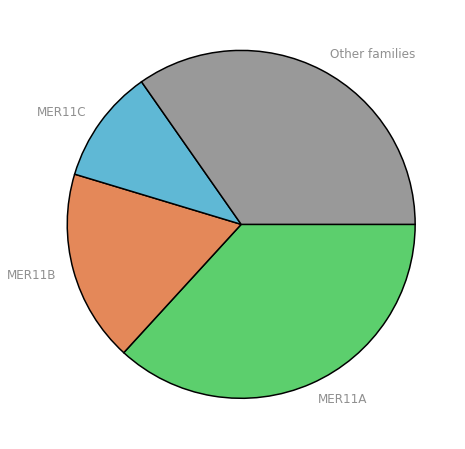

In [14]:
import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib.font_manager

fig, ax = plt.subplots(figsize=(8,8))
#plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size'] = 12

color_palette_list = ['#5ccf6d', '#e48859', '#5fb8d5', '#999999',]

labels = ['MER11A', 
          'MER11B',
          'MER11C',
          'Other families'
         ]

percentages = [kzfp_TE_group_df.loc['MER11A', 'percentage'], kzfp_TE_group_df.loc['MER11B', 'percentage'], kzfp_TE_group_df.loc['MER11C', 'percentage'], kzfp_TE_group_df[~kzfp_TE_group_df.index.isin(['MER11A', 'MER11B', 'MER11C'])]['percentage'].sum()]

explode=(0,0,0,0)
ax.pie(percentages, labels=labels,  
       colors=color_palette_list,
       shadow=False, startangle=0,    counterclock=False,
       wedgeprops = { 'linewidth':1.5, "edgecolor":"black", 'antialiased': True}
       )

#ax.set_title(krab_name)
#ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))